# Network Capture

## All top-level fields from Packet List View

In [17]:
import pandas as pd
df1 = pd.read_csv('data1.csv')
df1.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,10.240.180.150,10.240.180.126,CFLOW,778,IPFIX flow ( 736 bytes) Obs-Domain-ID= 0 [D...
1,2,0.000029,10.240.180.126,10.240.180.150,ICMP,590,Destination unreachable (Port unreachable)
2,3,0.071835,10.240.180.150,10.240.180.126,CFLOW,1498,IPFIX flow (1456 bytes) Obs-Domain-ID= 0 [D...
3,4,0.171614,10.240.180.150,10.240.180.126,CFLOW,1066,IPFIX flow (1024 bytes) Obs-Domain-ID= 0 [D...
4,5,0.190703,10.240.180.150,10.240.180.126,CFLOW,1498,IPFIX flow (1456 bytes) Obs-Domain-ID= 0 [D...


## timestamp field from IPFIX

In [18]:
df2 = pd.read_csv('data2.csv')

In [19]:
df2.head()

,cflow.timestamp,ip.src,ip.dst,ip.proto,cflow.len
0,Dec 20 2021 11:54:49.000000000,10.240.180.150,10.240.180.126,17,736
1,Dec 20 2021 11:54:50.000000000,10.240.180.150,10.240.180.126,17,1456
2,Dec 20 2021 11:54:49.000000000,10.240.180.150,10.240.180.126,17,1024
3,Dec 20 2021 11:54:50.000000000,10.240.180.150,10.240.180.126,17,1456
4,Dec 20 2021 11:54:50.000000000,10.240.180.150,10.240.180.126,17,1456


## Unique Connections

In [20]:
df1.groupby(["Source", 'Destination']).count().reset_index()

,Source,Destination,No.,Time,Protocol,Length,Info
0,10.240.180.126,10.240.180.150,48,48,48,48,48
1,10.240.180.150,10.240.180.126,119,119,119,119,119
2,AristaNe_16:0e:a1,Broadcast,12,12,12,12,12
3,Dell_16:3c:5c,AristaNe_16:0e:a1,15,15,15,15,15
4,Dell_16:3c:5c,Broadcast,6,6,6,6,6
5,Dell_42:5c:dd,Broadcast,1,1,1,1,1


## Connection Level Aggregations

In [21]:
df1.groupby(["Source", 'Destination']).agg(({'Time':'sum', 'Length':'mean'}))

Time      Length
Source            Destination                               
10.240.180.126    10.240.180.150     1523.115927  525.000000
10.240.180.150    10.240.180.126     3010.969010  910.840336
AristaNe_16:0e:a1 Broadcast           343.935627   68.000000
Dell_16:3c:5c     AristaNe_16:0e:a1   469.287328   42.000000
                  Broadcast           193.566216   42.000000
Dell_42:5c:dd     Broadcast            25.323772   60.000000

## Process packets only for a specified connection

In [22]:
def process(df, connection):
    filtered_df = df[(df["Source"] == connection.Source) & (df["Destination"] == connection.Destination)]
    return further_process(filtered_df)

## Time Series Modelling

In [23]:
df2.head()

,cflow.timestamp,ip.src,ip.dst,ip.proto,cflow.len
0,Dec 20 2021 11:54:49.000000000,10.240.180.150,10.240.180.126,17,736
1,Dec 20 2021 11:54:50.000000000,10.240.180.150,10.240.180.126,17,1456
2,Dec 20 2021 11:54:49.000000000,10.240.180.150,10.240.180.126,17,1024
3,Dec 20 2021 11:54:50.000000000,10.240.180.150,10.240.180.126,17,1456
4,Dec 20 2021 11:54:50.000000000,10.240.180.150,10.240.180.126,17,1456


In [24]:
b = df2.rename(columns={'cflow.timestamp':'ds','cflow.len':'y'})[{"ds", "y"}]

In [25]:
b.head()

,y,ds
0,736,Dec 20 2021 11:54:49.000000000
1,1456,Dec 20 2021 11:54:50.000000000
2,1024,Dec 20 2021 11:54:49.000000000
3,1456,Dec 20 2021 11:54:50.000000000
4,1456,Dec 20 2021 11:54:50.000000000


### Build the model

In [26]:
from prophet import Prophet
m = Prophet()
m.fit(b)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Make predictions

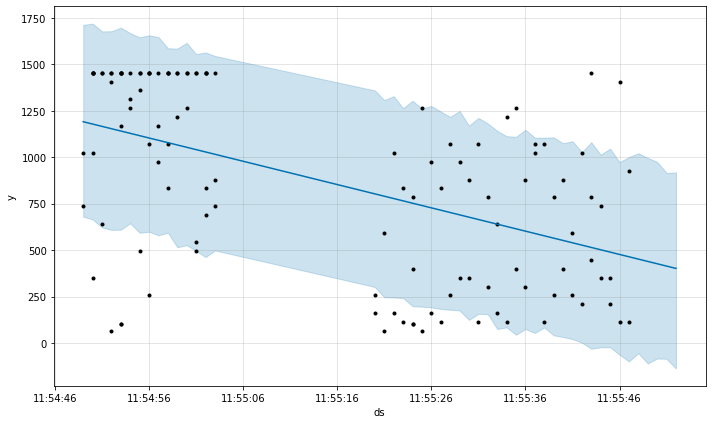

In [28]:
future = m.make_future_dataframe(periods=5, freq='s')
forecast = m.predict(future)
fig1 = m.plot(forecast)